In [244]:
import pandas as pd
import numpy as np
import time
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree, DecisionTreeRegressor
import xgboost as xgb

In [245]:
in_dir = Path("data/processed/03")
folds = {}
for i in range(1, 3):
    print(f"Reading fold {i}:")
    folds[f"fold_{i}"] = {
        "X_train": pd.read_csv(f'{in_dir}/fold_{i}_X_train.csv'),
        "X_test": pd.read_csv(f'{in_dir}/fold_{i}_X_test.csv'),
        "y_train": pd.read_csv(f'{in_dir}/fold_{i}_y_train.csv').squeeze(),
        "y_test": pd.read_csv(f'{in_dir}/fold_{i}_y_test.csv').squeeze()
    }

X_train = folds["fold_1"]["X_train"];
y_train = folds["fold_1"]["y_train"];
y_test = folds["fold_1"]["y_test"];

print("Ready for Feature Classification:")
print(f"  Training features: {X_train.shape}")
print(f"  Features to classify: {len(X_train.columns)}")
print(f"  Data integrity verified: ✅")

Reading fold 1:
Reading fold 2:
Ready for Feature Classification:
  Training features: (8495, 4)
  Features to classify: 4
  Data integrity verified: ✅


In [246]:
X_train.describe()

,num__temp_C,num__slp_hPa,dt__dt__hour,dt__dt__is_weekend
count,8.495000e+03,8.495000e+03,8.495000e+03,8.495000e+03
mean,8.029677e-17,2.970980e-15,-6.963235e-17,-6.942325e-17
std,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00
min,-3.002637e+00,-2.868419e+00,-1.613084e+00,-6.379050e-01
25%,-8.337260e-01,-6.852662e-01,-9.011579e-01,-6.379050e-01
50%,-9.539888e-03,-1.261662e-01,-4.684714e-02,-6.379050e-01
75%,7.604234e-01,7.257959e-01,9.498488e-01,1.567631e+00
max,2.571464e+00,3.028756e+00,1.661774e+00,1.567631e+00


In [247]:
pipeline = Pipeline(steps=[('regressor', LinearRegression())])

In [248]:
print(folds["fold_1"]["y_train"])

0       51.445213
1        4.155905
2        2.686866
3        2.109964
4        2.770088
          ...    
8490    15.906068
8491    14.350314
8492    16.194435
8493    16.287197
8494    18.220762
Name: y_train, Length: 8495, dtype: float64


In [249]:
for fold_name, d in folds.items():
    print(f"Processing {fold_name}...")

    X_train = d["X_train"].select_dtypes(include=np.number).copy()
    X_test  = d["X_test"].select_dtypes(include=np.number).copy()
    y_train = pd.to_numeric(d["y_train"], errors="coerce").squeeze()
    y_test  = pd.to_numeric(d["y_test"],  errors="coerce").squeeze()

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Test MSE for {fold_name}: {mse:.2f}")

Processing fold_1...
Test MSE for fold_1: 490.23
Processing fold_2...
Test MSE for fold_2: 408.16


In [250]:
for fold_name, d in folds.items():
    print(f"Processing {fold_name}...")

    X_train = d["X_train"].select_dtypes(include=np.number).copy()
    X_test  = d["X_test"].select_dtypes(include=np.number).copy()
    y_train = pd.to_numeric(d["y_train"], errors="coerce").squeeze()
    y_test  = pd.to_numeric(d["y_test"],  errors="coerce").squeeze()

    # Statistical selection (correlation-based)*
    selector = SelectKBest(score_func=f_regression, k=10)
    X_selected = selector.fit_transform(X_train, y_train)
    selected_features = X_train.columns[selector.get_support()]

    # Model-based selection*
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Get feature importances*
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"Feature importance for {fold_name}:/n{feature_importance}")

    # Select top features*
    top_features = feature_importance.head(10)['feature'].tolist()
    X_top = X_train[top_features]

    print(f"Top features for {fold_name}:/n{top_features}")

    # Recursive feature elimination*
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
    X_rfe = rfe.fit_transform(X_train, y_train)
    selected_features_rfe = X_train.columns[rfe.support_]

    print(f"Selected features for {fold_name}:/n{selected_features_rfe}")

    # PCA for dimensionality reduction*
    pca = PCA(n_components=0.95)  # Keep 95% of variance
    X_pca = pca.fit_transform(X_train)
    print(f"PCA reduced {X_train.shape[1]} features to {X_pca.shape[1]} components")

    # Compare methods*
    print("\nFeature Selection Comparison:")
    print(f"Statistical selection: {len(selected_features)} features")
    print(f"Importance-based: {len(top_features)} features")
    print(f"RFE: {len(selected_features_rfe)} features")
    print(f"PCA: {X_pca.shape[1]} components")

Processing fold_1...


/nix/store/2psxf7a7lra916jd0wbafviqz53fb7kj-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=4. All the features will be returned.
  warnings.warn(


Feature importance for fold_1:/n              feature  importance
0         num__temp_C    0.357921
1        num__slp_hPa    0.329869
2        dt__dt__hour    0.266288
3  dt__dt__is_weekend    0.045921
Top features for fold_1:/n['num__temp_C', 'num__slp_hPa', 'dt__dt__hour', 'dt__dt__is_weekend']
Selected features for fold_1:/nIndex(['num__temp_C', 'num__slp_hPa', 'dt__dt__hour', 'dt__dt__is_weekend'], dtype='object')
PCA reduced 4 features to 4 components

Feature Selection Comparison:
Statistical selection: 4 features
Importance-based: 4 features
RFE: 4 features
PCA: 4 components
Processing fold_2...


/nix/store/2psxf7a7lra916jd0wbafviqz53fb7kj-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=4. There will be no feature selection and all features will be kept.
  warnings.warn(
/nix/store/2psxf7a7lra916jd0wbafviqz53fb7kj-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=4. All the features will be returned.
  warnings.warn(


Feature importance for fold_2:/n              feature  importance
0         num__temp_C    0.359550
1        num__slp_hPa    0.343849
2        dt__dt__hour    0.252157
3  dt__dt__is_weekend    0.044444
Top features for fold_2:/n['num__temp_C', 'num__slp_hPa', 'dt__dt__hour', 'dt__dt__is_weekend']
Selected features for fold_2:/nIndex(['num__temp_C', 'num__slp_hPa', 'dt__dt__hour', 'dt__dt__is_weekend'], dtype='object')
PCA reduced 4 features to 4 components

Feature Selection Comparison:
Statistical selection: 4 features
Importance-based: 4 features
RFE: 4 features
PCA: 4 components


/nix/store/2psxf7a7lra916jd0wbafviqz53fb7kj-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=4. There will be no feature selection and all features will be kept.
  warnings.warn(


In [251]:
model = LinearRegression()
model.fit(X_train, y_train)
print(f"Score: {model.score(X_test, y_test):.3f}")

Score: -0.293


In [252]:
# View coefficients*
coefs = pd.DataFrame({'feature': X_train.columns, 'impact': model.coef_})
print(coefs.sort_values('impact', key=abs, ascending=False))

              feature    impact
2        dt__dt__hour  8.652682
0         num__temp_C -5.717183
3  dt__dt__is_weekend -3.539633
1        num__slp_hPa  0.928225


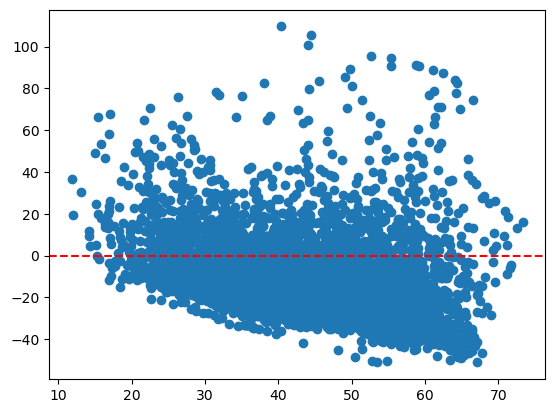

In [253]:
residuals = y_test - model.predict(X_test)
plt.scatter(model.predict(X_test), residuals)
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [254]:
ridge = Ridge(alpha=1.0)  # alpha controls penalty strength
lasso = Lasso(alpha=0.1)
ridge = RidgeCV(alphas=[0.1, 1, 10])  # Auto-selects best alpha
ridge.fit(X_train, y_train)
print(f"Best alpha: {ridge.alpha_}")

Best alpha: 10.0


In [255]:
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
selected_features = X_train.columns[lasso.coef_ != 0]
print(f"Selected: {list(selected_features)}")

Selected: ['num__temp_C', 'num__slp_hPa', 'dt__dt__hour', 'dt__dt__is_weekend']


In [256]:
grid = GridSearchCV(Ridge(), {'alpha': [0.1, 1, 10]}, cv=5)
grid.fit(X_train, y_train)
print(f"Best alpha: {grid.best_params_}")

Best alpha: {'alpha': 10}


In [257]:
models = {'Linear': LinearRegression(), 'Ridge': RidgeCV(), 'Lasso': LassoCV()}
for fold_name, d in folds.items():
    print(f"Processing {fold_name}...")

    X_train = d["X_train"].select_dtypes(include=np.number).copy()
    X_test  = d["X_test"].select_dtypes(include=np.number).copy()
    y_train = pd.to_numeric(d["y_train"], errors="coerce").squeeze()
    y_test  = pd.to_numeric(d["y_test"],  errors="coerce").squeeze()
    for name, model in models.items():
        score = cross_val_score(model, X_train, y_train, cv=5).mean()
        print(f"{name}: {score:.3f}")

Processing fold_1...
Linear: 0.178
Ridge: 0.178
Lasso: 0.177
Processing fold_2...
Linear: 0.143
Ridge: 0.143
Lasso: 0.144


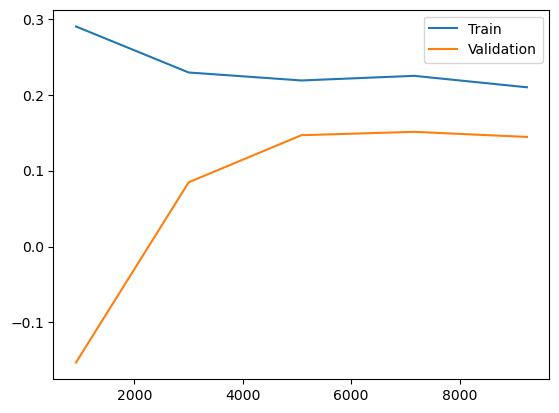

In [258]:
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation')
plt.legend()
plt.show()

In [259]:
model = LinearRegression()
model.fit(X_train, y_train)

print("Model Results:")
print(f"R² Score: {model.score(X_test, y_test):.3f}")
print(f"Intercept: {model.intercept_:.3f}")
print(f"Coefficients: {model.coef_}")

Model Results:
R² Score: -0.293
Intercept: 42.113
Coefficients: [-5.71718325  0.92822512  8.65268168 -3.53963332]


In [260]:
predictions = model.predict(X_test)
residuals = y_test - predictions

print("Residual Analysis:")
print(f"Average residual: {residuals.mean():.3f}")
print(f"Largest error: {abs(residuals).max():.3f}")
print(f"Standard deviation: {residuals.std():.3f}")

Residual Analysis:
Average residual: -10.394
Largest error: 109.631
Standard deviation: 17.326


In [261]:
r2 = model.score(X_test, y_test)

print(f"R-squared: {r2:.3f}")
print(f"Model explains {r2*100:.1f}% of the variation")

if r2 > 0.7:
    print("✅ Good model!")
elif r2 > 0.5:
    print("⚠️ Okay model")
else:
    print("❌ Needs improvement")

R-squared: -0.293
Model explains -29.3% of the variation
❌ Needs improvement


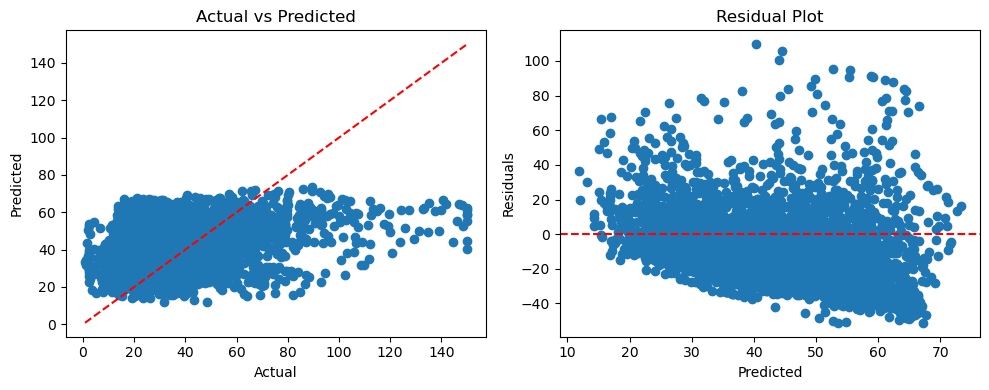

In [262]:
# Simple diagnostic plots
predictions = model.predict(X_test)
residuals = y_test - predictions

# Plot 1: Actual vs Predicted
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

# Plot 2: Residuals
plt.subplot(1, 2, 2)
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

In [263]:
features = ['num__temp_C', 'num__slp_hPa', 'dt__dt__hour', 'dt__dt__is_weekend']
coefficients = model.coef_

print("MODEL EXPLANATION FOR STAKEHOLDERS")
print("="*40)
print(f"Model accuracy: {model.score(X_test, y_test)*100:.0f}%")
print("\nKey findings:")

for feature, coef in zip(features, coefficients):
    if coef > 0:
        print(f"• {feature}: +{coef:.0f} impact per unit increase")
    else:
        print(f"• {feature}: {coef:.0f} impact per unit increase")

print(f"\nTypical prediction error: ±{abs(residuals).mean():.0f}")

MODEL EXPLANATION FOR STAKEHOLDERS
Model accuracy: -29%

Key findings:
• num__temp_C: -6 impact per unit increase
• num__slp_hPa: +1 impact per unit increase
• dt__dt__hour: +9 impact per unit increase
• dt__dt__is_weekend: -4 impact per unit increase

Typical prediction error: ±17


In [264]:
# Simple assumption checks*
predictions = model.predict(X_test)
residuals = y_test - predictions

print("ASSUMPTION CHECKS")
print("="*20)

# Check 1: Linear relationship
correlation = np.corrcoef(predictions, residuals)[0, 1]
if abs(correlation) < 0.1:
    print("✅ Linear relationship looks good")
else:
    print("⚠️ May need non-linear terms")

# Check 2: Residual distribution
if abs(residuals.mean()) < 0.1:
    print("✅ Residuals centered at zero")
else:
    print("⚠️ Model may be biased")

# Check 3: Outliers
outlier_count = sum(abs(residuals) > 2 * residuals.std())
if outlier_count < len(residuals) * 0.05:
    print("✅ Few outliers detected")
else:
    print("⚠️ Many outliers - check data quality")

ASSUMPTION CHECKS
⚠️ May need non-linear terms
⚠️ Model may be biased
⚠️ Many outliers - check data quality


In [265]:
# Test model on different data subsets
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

print("CROSS-VALIDATION RESULTS")
print("="*30)
print(f"Individual scores: {cv_scores}")
print(f"Average score: {cv_scores.mean():.3f}")
print(f"Standard deviation: {cv_scores.std():.3f}")

# Interpretation
if cv_scores.std() < 0.1:
    print("✅ Model performance is consistent")
else:
    print("⚠️ Model performance varies significantly")

if cv_scores.mean() > 0.7:
    print("✅ Good average performance")
else:
    print("⚠️ Performance needs improvement")

CROSS-VALIDATION RESULTS
Individual scores: [0.2366788  0.1041226  0.14886995 0.14561186 0.08157148]
Average score: 0.143
Standard deviation: 0.053
✅ Model performance is consistent
⚠️ Performance needs improvement


In [266]:
# Simple monitoring setup
def monitor_model(model, new_X, new_y):
    """Monitor model performance on new data"""
    predictions = model.predict(new_X)
    current_r2 = model.score(new_X, new_y)
    residuals = new_y - predictions
    
    print("MODEL MONITORING REPORT")
    print("="*30)
    print(f"Current R²: {current_r2:.3f}")
    print(f"Average error: {abs(residuals).mean():.3f}")
    print(f"Max error: {abs(residuals).max():.3f}")
    
    # Alert thresholds
    if current_r2 < 0.5:
        print("🚨 ALERT: Model performance degraded")
    elif current_r2 < 0.7:
        print("⚠️ WARNING: Monitor closely")
    else:
        print("✅ Model performing well")
    
    return current_r2, residuals.mean()

In [267]:
# Complete model review function
def complete_model_review(model, X_test, y_test, feature_names):
    """Run complete model review"""
    print("COMPLETE MODEL REVIEW")
    print("="*40)
    
    # Performance
    r2 = model.score(X_test, y_test)
    predictions = model.predict(X_test)
    residuals = y_test - predictions
    
    print(f"1. Performance: R² = {r2:.3f}")
    
    # Coefficients
    print("2. Coefficients:")
    for name, coef in zip(feature_names, model.coef_):
        print(f"   {name}: {coef:.3f}")
    
    # Residuals
    print(f"3. Residuals: Mean = {residuals.mean():.3f}")
    
    # Outliers
    outliers = sum(abs(residuals) > 2 * residuals.std())
    print(f"4. Outliers: {outliers} found")
    
    # Overall assessment
    print("\n5. OVERALL ASSESSMENT:")
    if r2 > 0.7 and abs(residuals.mean()) < 0.1:
        print("   ✅ Model ready for use")
    else:
        print("   ⚠️ Model needs improvement")

# Example usage# complete_model_review(model, X_test, y_test, ['Feature1', 'Feature2'])

In [268]:
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
print(f"Tree R²: {tree.score(X_test, y_test):.3f}")

Tree R²: -0.322


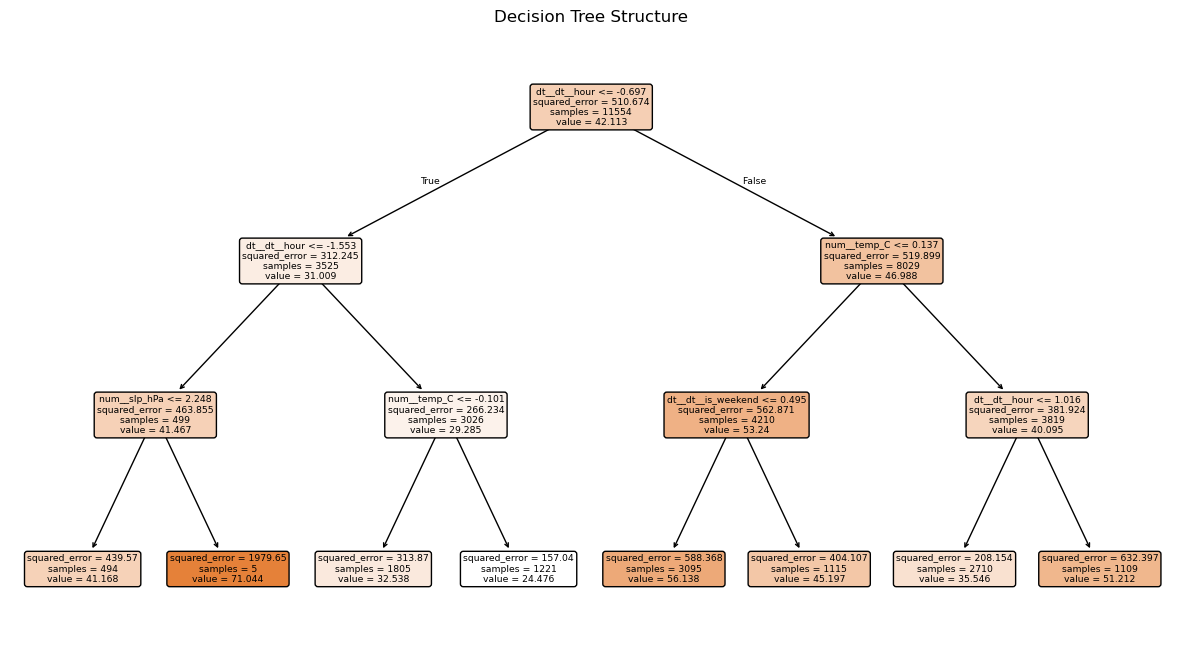

In [269]:
# Train simple tree for visualization
tree = DecisionTreeRegressor(max_depth=3, min_samples_split=10)
tree.fit(X_train, y_train)

# Visualize tree structure
plt.figure(figsize=(15, 8))
plot_tree(tree, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Decision Tree Structure")
plt.show()

In [270]:
# Test different max_depth values*
depths = [3, 5, 7, 10, None]
for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    cv_scores = cross_val_score(tree, X_train, y_train, cv=5)
    print(f"Depth {depth}: CV R² = {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Depth 3: CV R² = 0.137 ± 0.067
Depth 5: CV R² = 0.149 ± 0.077
Depth 7: CV R² = 0.071 ± 0.116
Depth 10: CV R² = -0.077 ± 0.132
Depth None: CV R² = -0.602 ± 0.292


In [271]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
print(f"Random Forest R²: {rf.score(X_test, y_test):.3f}")
# Compare with single tree
tree = DecisionTreeRegressor(max_depth=10, random_state=42)
tree.fit(X_train, y_train)
print(f"Single Tree R²: {tree.score(X_test, y_test):.3f}")

Random Forest R²: -0.345
Single Tree R²: -0.604


Top 10 Most Important Features:
              feature  importance
2        dt__dt__hour    0.368837
0         num__temp_C    0.319937
1        num__slp_hPa    0.245557
3  dt__dt__is_weekend    0.065669


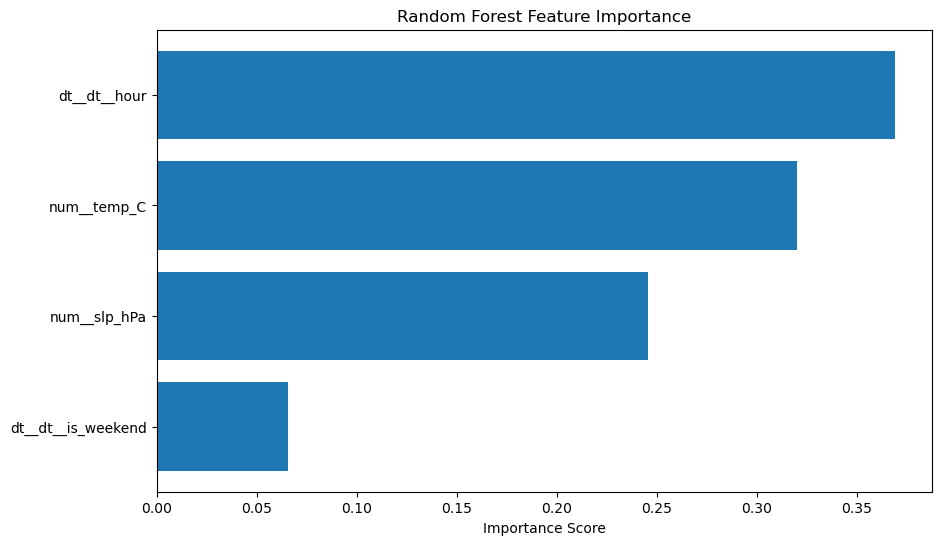

In [272]:
# Get feature importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Visualize importance
plt.figure(figsize=(10, 6))
top_features = importance_df.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [273]:
# Compare training speed
start_time = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_time = time.time() - start_time

start_time = time.time()
et = ExtraTreesRegressor(n_estimators=100, random_state=42)
et.fit(X_train, y_train)
et_time = time.time() - start_time

print(f"Random Forest - Time: {rf_time:.2f}s, R²: {rf.score(X_test, y_test):.3f}")
print(f"Extra Trees - Time: {et_time:.2f}s, R²: {et.score(X_test, y_test):.3f}")

Random Forest - Time: 1.76s, R²: -0.538
Extra Trees - Time: 0.88s, R²: -0.556


Gradient Boosting R²: -0.292


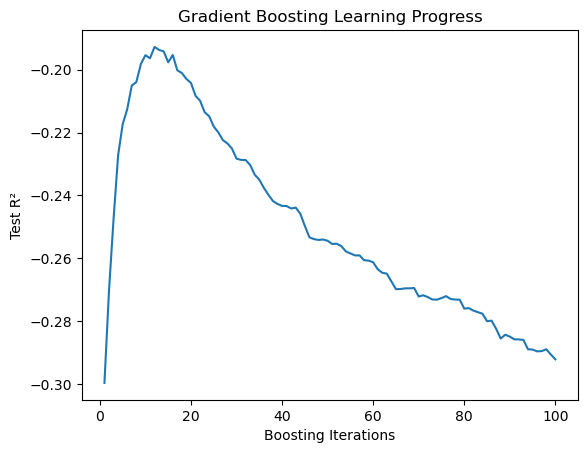

In [274]:
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)
print(f"Gradient Boosting R²: {gb.score(X_test, y_test):.3f}")

# Show learning progress
test_scores = []
for i, pred in enumerate(gb.staged_predict(X_test)):
    score = r2_score(y_test, pred)
    test_scores.append(score)

plt.plot(range(1, len(test_scores) + 1), test_scores)
plt.xlabel('Boosting Iterations')
plt.ylabel('Test R²')
plt.title('Gradient Boosting Learning Progress')
plt.show()

In [275]:
# XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
print(f"XGBoost R²: {r2_score(y_test, xgb_pred):.3f}")

# Feature importance
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 5 XGBoost Features:")
print(xgb_importance.head())

XGBoost R²: -0.375

Top 5 XGBoost Features:
              feature  importance
2        dt__dt__hour    0.409443
3  dt__dt__is_weekend    0.329429
0         num__temp_C    0.158561
1        num__slp_hPa    0.102566


In [276]:
# Random Forest tuning
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt', 'log2', 0.5]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)
print(f"Best RF params: {rf_grid.best_params_}")
print(f"Best RF score: {rf_grid.best_score_:.3f}")

Best RF params: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
Best RF score: 0.187


In [277]:

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

results = []
for name, model in models.items():
    # Time training
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Evaluate performance
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'R²': r2,
        'Train_Time': train_time
    })

comparison_df = pd.DataFrame(results)
print("Model Comparison:")
print(comparison_df.round(3))

Model Comparison:
               Model     R²  Train_Time
0      Random Forest -0.538       1.789
1        Extra Trees -0.556       0.866
2  Gradient Boosting -0.292       0.439
3            XGBoost -0.539       0.178


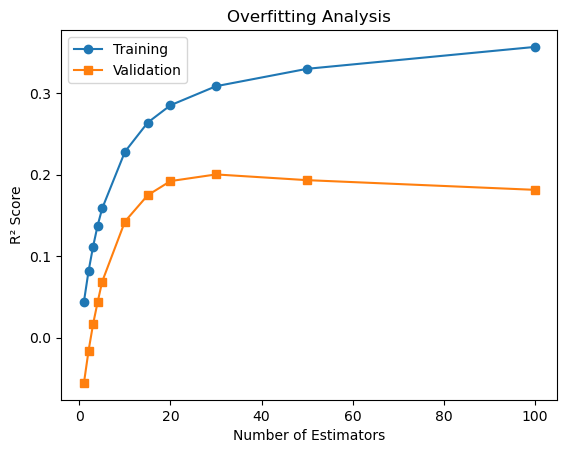

In [278]:
# Monitor overfitting with validation curves
train_scores = []
val_scores = []
n_estimators_range = [1, 2, 3, 4, 5, 10, 15, 20, 30, 50, 100]

for n_est in n_estimators_range:
    rf = GradientBoostingRegressor(n_estimators=n_est, random_state=42)
    
    # Cross-validation
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
    
    # Training score
    rf.fit(X_train, y_train)
    train_score = rf.score(X_train, y_train)
    
    train_scores.append(train_score)
    val_scores.append(cv_scores.mean())

# Plot overfitting analysis
plt.plot(n_estimators_range, train_scores, 'o-', label='Training')
plt.plot(n_estimators_range, val_scores, 's-', label='Validation')
plt.xlabel('Number of Estimators')
plt.ylabel('R² Score')
plt.title('Overfitting Analysis')
plt.legend()
plt.show()

In [279]:
# Comprehensive tree model diagnostics
def tree_diagnostics(model, X_train, X_test, y_train, y_test):
    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Basic performance
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    
    print(f"Model Performance:")
    print(f"  R²: {r2:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    
    # Feature importance
    if hasattr(model, 'feature_importances_'):
        importance = pd.Series(model.feature_importances_, index=X_train.columns)
        print(f"\nTop 5 features: {importance.nlargest(5).index.tolist()}")
    
    # Out-of-bag score (if available)
    if hasattr(model, 'oob_score_') and model.oob_score_:
        print(f"  OOB Score: {model.oob_score_:.3f}")
    
    # Residual analysis
    residuals = y_test - y_pred
    print(f"\nResidual Analysis:")
    print(f"  Mean residual: {residuals.mean():.6f}")
    print(f"  Residual std: {residuals.std():.3f}")
    
    return r2, rmse


gb = GradientBoostingRegressor(n_estimators=10, random_state=42)
r2, rmse = tree_diagnostics(gb, X_train, X_test, y_train, y_test)

Model Performance:
  R²: -0.195
  RMSE: 19.423

Top 5 features: ['dt__dt__hour', 'num__temp_C', 'dt__dt__is_weekend', 'num__slp_hPa']

Residual Analysis:
  Mean residual: -10.408059
  Residual std: 16.400


In [280]:
# Complete tree ensemble project framework
class TreeEnsembleProject:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.results = {}
        self.best_model = None
        
    def run_baseline_comparison(self):
        """Compare baseline tree ensemble models"""
        models = {
            'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
        }
        
        for name, model in models.items():
            # Cross-validation*
            cv_scores = cross_val_score(model, X_train, y_train, cv=5)
            
            # Test performance*
            model.fit(X_train, y_train)
            test_score = model.score(X_test, y_test)
            
            self.results[name] = {
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'test_score': test_score,
                'model': model
            }
            
            print(f"{name}: CV {cv_scores.mean():.3f}±{cv_scores.std():.3f}, Test {test_score:.3f}")
    
    def select_best_model(self):
        """Identify best performing model"""
        best_cv_score = max(self.results.keys(), key=lambda k: self.results[k]['cv_mean'])
        self.best_model = self.results[best_cv_score]['model']
        print(f"\nBest model: {best_cv_score}")
        return best_cv_score
    
    def generate_report(self):
        """Generate comprehensive project report"""
        print("\n" + "="*50)
        print("TREE ENSEMBLE PROJECT SUMMARY")
        print("="*50)
        
        # Performance ranking
        sorted_models = sorted(self.results.items(), key=lambda x: x[1]['cv_mean'], reverse=True)
        
        print("\nModel Rankings (by CV performance):")
        for i, (name, results) in enumerate(sorted_models, 1):
            print(f"{i}. {name}: {results['cv_mean']:.3f}±{results['cv_std']:.3f}")
        
        # Best model details
        best_name = sorted_models[0][0]
        best_results = sorted_models[0][1]
        
        print(f"\nRecommended Model: {best_name}")
        print(f"Cross-validation R²: {best_results['cv_mean']:.3f}")
        print(f"Test R²: {best_results['test_score']:.3f}")
        
        print(f"\nKey Findings:")
        print(f"• Best performing approach: {best_name}")
        print(f"• Performance stability: {best_results['cv_std']:.3f} CV standard deviation")
        print(f"• Generalization gap: {abs(best_results['cv_mean'] - best_results['test_score']):.3f}")

# Execute complete project

for fold_name, d in folds.items():
    print(f"Processing {fold_name}...")

    X_train = d["X_train"].select_dtypes(include=np.number).copy()
    X_test  = d["X_test"].select_dtypes(include=np.number).copy()
    y_train = pd.to_numeric(d["y_train"], errors="coerce").squeeze()
    y_test  = pd.to_numeric(d["y_test"],  errors="coerce").squeeze()
    project = TreeEnsembleProject(X_train, y_train, X_test, y_test)
    project.run_baseline_comparison()
    best_model_name = project.select_best_model()
    project.generate_report()

    print(f"\nProject completed! Best model: {best_model_name}")
    print("Next steps: Hyperparameter tuning, feature analysis, deployment preparation")

Processing fold_1...
Decision Tree: CV -0.136±0.131, Test -0.130
Random Forest: CV 0.039±0.109, Test -0.028
Extra Trees: CV 0.015±0.128, Test -0.070
Gradient Boosting: CV 0.174±0.083, Test 0.141
XGBoost: CV -0.055±0.138, Test -0.087

Best model: Gradient Boosting

TREE ENSEMBLE PROJECT SUMMARY

Model Rankings (by CV performance):
1. Gradient Boosting: 0.174±0.083
2. Random Forest: 0.039±0.109
3. Extra Trees: 0.015±0.128
4. XGBoost: -0.055±0.138
5. Decision Tree: -0.136±0.131

Recommended Model: Gradient Boosting
Cross-validation R²: 0.174
Test R²: 0.141

Key Findings:
• Best performing approach: Gradient Boosting
• Performance stability: 0.083 CV standard deviation
• Generalization gap: 0.032

Project completed! Best model: Gradient Boosting
Next steps: Hyperparameter tuning, feature analysis, deployment preparation
Processing fold_2...
Decision Tree: CV -0.077±0.132, Test -0.604
Random Forest: CV 0.022±0.118, Test -0.538
Extra Trees: CV -0.013±0.127, Test -0.556
Gradient Boosting: CV 

=== Evaluating LinearRegression() ===
==== Processing fold_1... ====
MSE: 490.228
RMSE: 22.141
RMSE as % of target mean: 47.6%
MAE: 16.056
RMSE/MAE ratio: 1.38
R²: 0.097
Model explains 9.7% of target variance
Adjusted R²: 0.096
MAPE: 39.0%


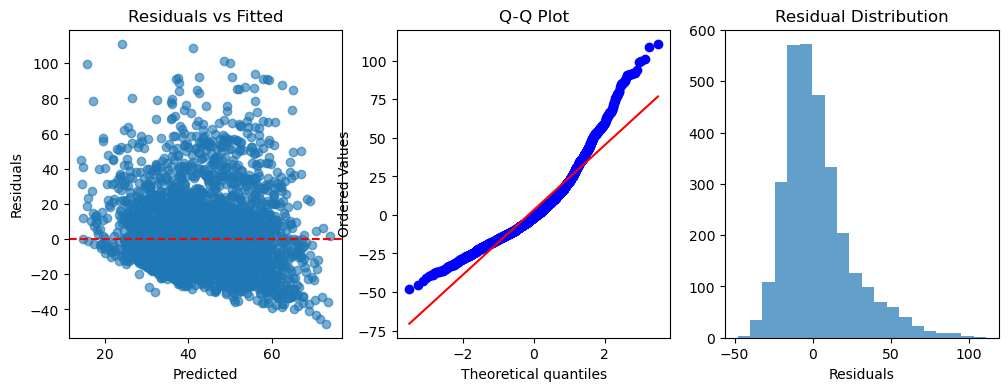

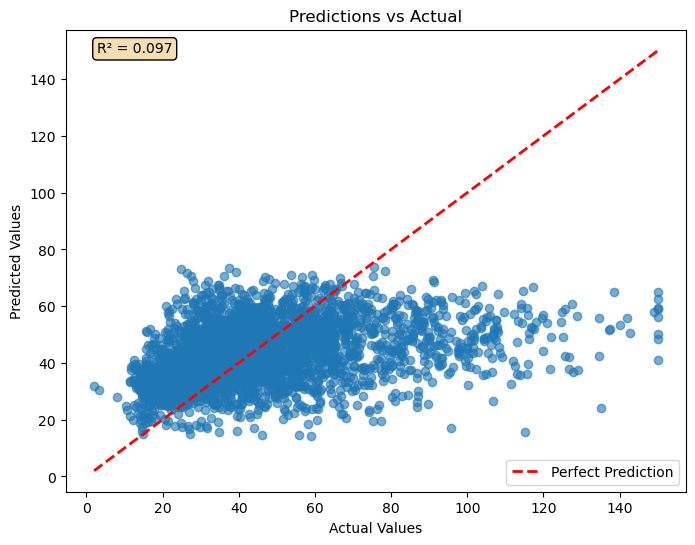

==== Processing fold_2... ====
MSE: 408.164
RMSE: 20.203
RMSE as % of target mean: 63.5%
MAE: 16.548
RMSE/MAE ratio: 1.22
R²: -0.293
Model explains -29.3% of target variance
Adjusted R²: -0.294
MAPE: 79.4%


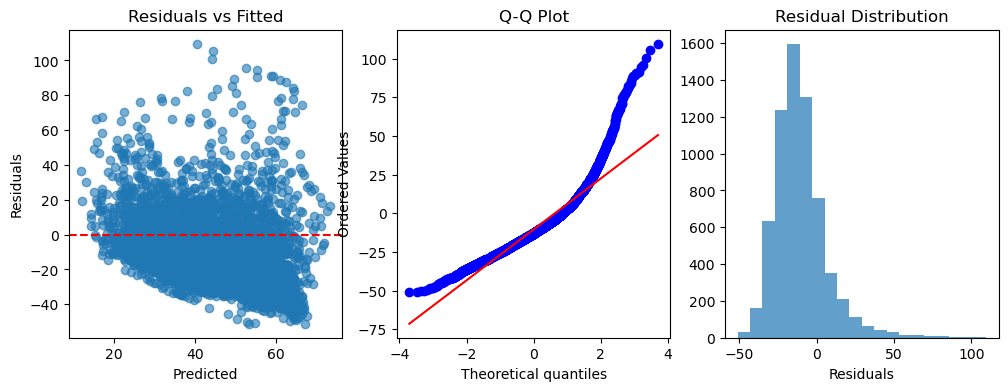

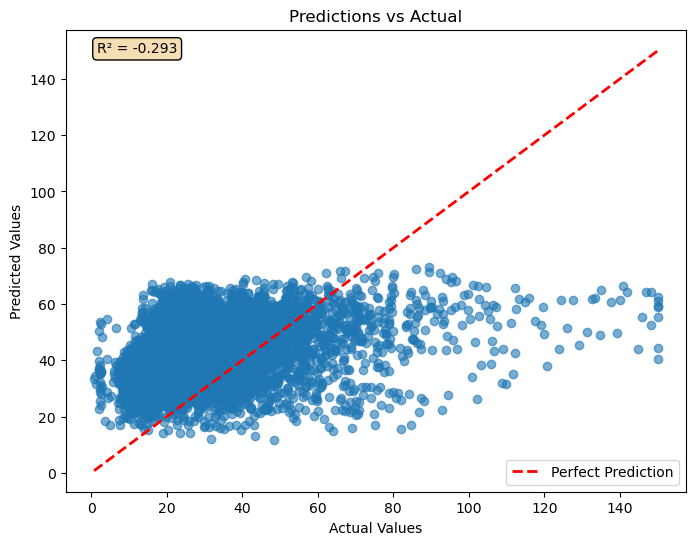

=== Evaluating GradientBoostingRegressor(n_estimators=15, random_state=42) ===
==== Processing fold_1... ====
MSE: 461.797
RMSE: 21.489
RMSE as % of target mean: 46.2%
MAE: 15.391
RMSE/MAE ratio: 1.40
R²: 0.149
Model explains 14.9% of target variance
Adjusted R²: 0.148
MAPE: 36.7%


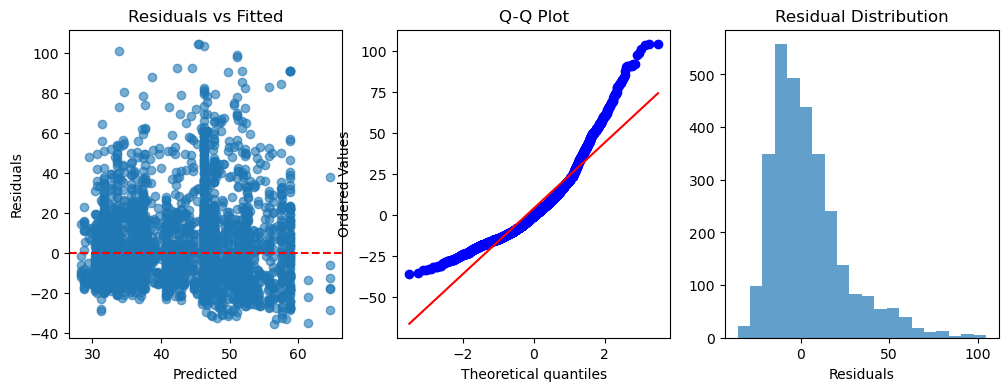

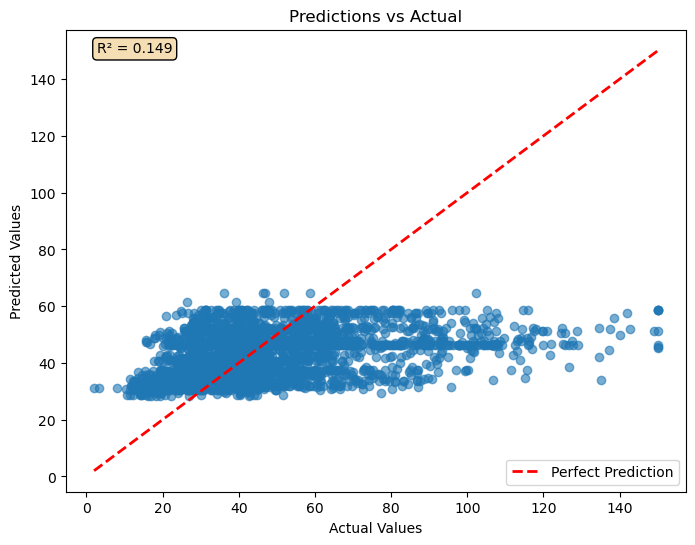

==== Processing fold_2... ====
MSE: 377.975
RMSE: 19.442
RMSE as % of target mean: 61.1%
MAE: 16.104
RMSE/MAE ratio: 1.21
R²: -0.198
Model explains -19.8% of target variance
Adjusted R²: -0.198
MAPE: 78.9%


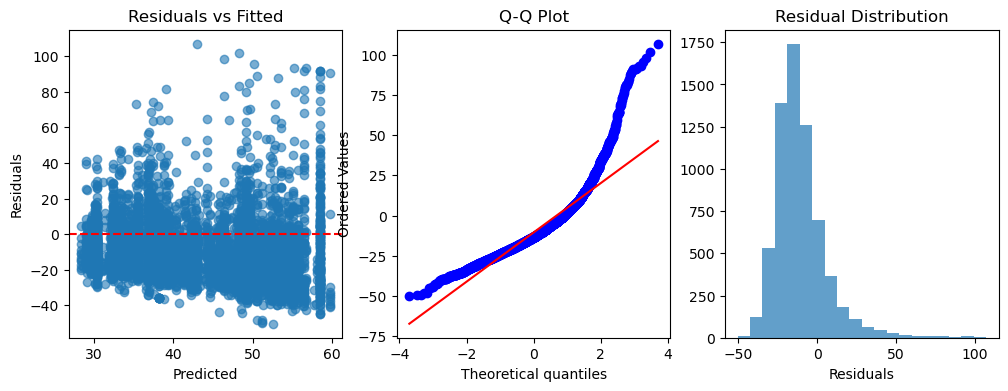

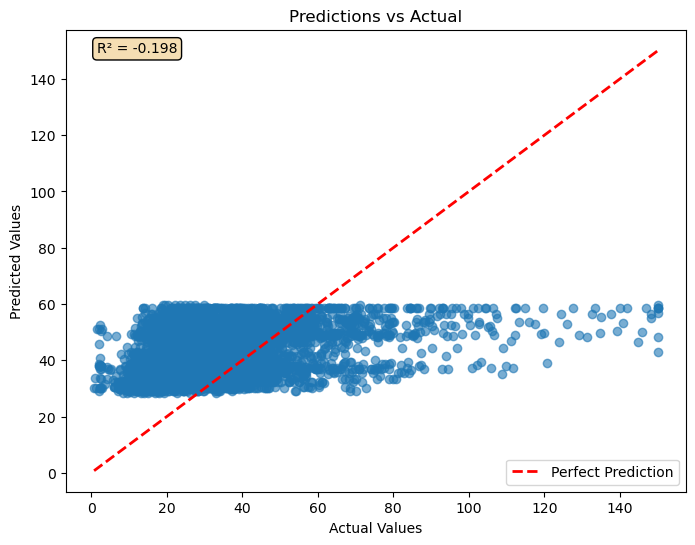

In [312]:
for model in [LinearRegression(), GradientBoostingRegressor(n_estimators=15, random_state=42)]:
    print(f"=== Evaluating {model} ===")
    for fold_name, d in folds.items():
        print(f"==== Processing {fold_name}... ====")

        X_train = d["X_train"].select_dtypes(include=np.number).copy()
        X_test  = d["X_test"].select_dtypes(include=np.number).copy()
        y_train = pd.to_numeric(d["y_train"], errors="coerce").squeeze()
        y_test  = pd.to_numeric(d["y_test"],  errors="coerce").squeeze()

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred)**0.5
        print(f"MSE: {mse:.3f}")
        print(f"RMSE: {rmse:.3f}")
        # Compare to target scale*
        print(f"RMSE as % of target mean: {rmse/y_test.mean()*100:.1f}%")   

        mae = mean_absolute_error(y_test, y_pred)
        ratio = rmse / mae
        print(f"MAE: {mae:.3f}")
        print(f"RMSE/MAE ratio: {ratio:.2f}")
        if ratio > 1.4:
            print("⚠️  Large prediction outliers detected")

        r2 = r2_score(y_test, y_pred)
        print(f"R²: {r2:.3f}")
        print(f"Model explains {r2*100:.1f}% of target variance")

        # Adjusted R² for feature count consideration
        n_samples, n_features = X_test.shape
        adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)
        print(f"Adjusted R²: {adj_r2:.3f}")

        def safe_mape(y_true, y_pred):
            # Avoid division by very small numbers*
            mask = np.abs(y_true) > 0.01 # Adjust threshold as needed
            if mask.sum() == 0:
                return float('inf')
            return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

        mape = safe_mape(y_test, y_pred)
        print(f"MAPE: {mape:.1f}%")

        residuals = y_test - y_pred

        # Residuals vs fitted plot
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.scatter(y_pred, residuals, alpha=0.6)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Predicted')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Fitted')

        # Q-Q plot
        from scipy.stats import probplot
        plt.subplot(1, 3, 2)
        probplot(residuals, dist="norm", plot=plt)
        plt.title('Q-Q Plot')

        # Histogram
        plt.subplot(1, 3, 3)
        plt.hist(residuals, bins=20, alpha=0.7)
        plt.xlabel('Residuals')
        plt.title('Residual Distribution')
        plt.show()

        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Predictions vs Actual')
        plt.legend()

        # Add R² to plot
        r2 = r2_score(y_test, y_pred)
        plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes,
                bbox=dict(boxstyle="round", facecolor='wheat'))
        plt.show()